In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.transforms import ToTensor
import tensorflow as tf

from torch.autograd import Variable
import torch.nn as nn

from tensorflow import keras 
from keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, regularizers, layers
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, KFold, train_test_split,StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Get data sets

In [ ]:
df_img = pd.read_csv("/content/gdrive/My Drive/Speciale/df_MRI_features_12042022", sep=",", header=0)
df_img = df_img.set_index("id")
df_img = df_img.drop(["Unnamed: 0"],axis=1)

var_of_interest =["v1: Femur (vol)","v1: JWS (approx)", "v1: Img Intensity (mean)", "v1: Tibial Intensity (mean)", "v1: Femur Intensity (mean)", 
                   "v1: Miniscus Intensity (mean)", "v1: Entropy Tibial", "v1: Entropy Meniscus","v1: Entropy Femur","v1: Closing Femur","v1: Closing Tibial",
                   "v1: Closing Meniscus","v1: Thick Femur X","v1: Thick Tibial X","v1: Thick Meniscus X",
                   "v2: Femur (vol)","v2: JWS (approx)", "v2: Img Intensity (mean)", "v2: Tibial Intensity (mean)", "v2: Femur Intensity (mean)", 
                   "v2: Miniscus Intensity (mean)", "v2: Entropy Tibial", "v2: Entropy Meniscus","v2: Entropy Femur","v2: Closing Femur","v2: Closing Tibial",
                   "v2: Closing Meniscus","v2: Thick Femur X","v2: Thick Tibial X","v2: Thick Meniscus X",
                   "v3: Femur (vol)","v3: JWS (approx)", "v3: Img Intensity (mean)", "v3: Tibial Intensity (mean)", "v3: Femur Intensity (mean)", 
                   "v3: Miniscus Intensity (mean)", "v3: Entropy Tibial", "v3: Entropy Meniscus","v3: Entropy Femur","v3: Closing Femur","v3: Closing Tibial",
                   "v3: Closing Meniscus","v3: Thick Femur X","v3: Thick Tibial X","v3: Thick Meniscus X", 'y']
    
df_img = df_img[var_of_interest]
df_img["id"]=df_img.index

df_clin = pd.read_csv("/content/gdrive/My Drive/Speciale/clindata_new_25042022", sep=",", header=0)
#df_clin = pd.read_csv("C:/Users/python_test/Desktop/Speciale/clindata_new_25042022", sep=",", header=0)
df_clin = df_clin.set_index("iD")
df_clin = df_clin.drop(["Unnamed: 0","y"],axis=1)
df_clin.index = [i.replace("_","-") for i in df_clin.index]
df_clin = df_clin.rename( index={'iD': 'id'})

## Merge datasets

In [ ]:
df_combi = df_clin.join(df_img).dropna()

In [ ]:
df_combi.columns.tolist()
col_order = ['Sex (V0)', 'Lives with a Spouse(V0)', 'Other People in Household',
             "Total Family History", 'Mom had TKR-surgery', 'Dad had TKR-surgery', 'Brother had TKR-surgery', 'Sister had TKR-surgery',
             'WOMAC Disability Score (calc) (v1)','WOMAC Pain Score (calc) (v1)', 'WOMAC Stiffness Score (calc) (v1)',
             'Fall within last 12 month (v1)', 'Upstairs, last 7 days (V1)','Get out of bed, last 7 days (V1)',#,'BMI (V1)'
             'Socks off, last 7 days (V1)', 'modified lifestyle (V1)', 'Physical Activity Scale (V1)', 'Broke or fractured bone (V1)',
             "v1: Femur (vol)","v1: JWS (approx)", "v1: Img Intensity (mean)", "v1: Tibial Intensity (mean)", "v1: Femur Intensity (mean)", 
             "v1: Miniscus Intensity (mean)", "v1: Entropy Tibial", "v1: Entropy Meniscus","v1: Entropy Femur","v1: Closing Femur","v1: Closing Tibial",
             "v1: Closing Meniscus","v1: Thick Femur X","v1: Thick Tibial X","v1: Thick Meniscus X",
             'WOMAC Disability Score (calc) (v2)','WOMAC Pain Score (calc) (v2)', 'WOMAC Stiffness Score (calc) (v2)',
             'Fall within last 12 month (v2)', 'Upstairs, last 7 days (V2)','Get out of bed, last 7 days (V2)',#'BMI (V2)',
             'Socks off, last 7 days (V2)', 'modified lifestyle (V2)', 'Physical Activity Scale (V2)', 'Broke or fractured bone (V2)',
            "v2: Femur (vol)","v2: JWS (approx)", "v2: Img Intensity (mean)", "v2: Tibial Intensity (mean)", "v2: Femur Intensity (mean)", 
            "v2: Miniscus Intensity (mean)", "v2: Entropy Tibial", "v2: Entropy Meniscus","v2: Entropy Femur","v2: Closing Femur","v2: Closing Tibial",
            "v2: Closing Meniscus","v2: Thick Femur X","v2: Thick Tibial X","v2: Thick Meniscus X",             
             'WOMAC Disability Score (calc) (v3)','WOMAC Pain Score (calc) (v3)', 'WOMAC Stiffness Score (calc) (v3)',
             'Fall within last 12 month (v3)', 'Upstairs, last 7 days (V3)','Get out of bed, last 7 days (V3)', #,'BMI (V3)'
             'Socks off, last 7 days (V3)', 'Modified lifestyle (V3)', 'Physical Activity Scale (V3)', 'Broke or fractured bone (V3)',
             "v3: Femur (vol)","v3: JWS (approx)", "v3: Img Intensity (mean)", "v3: Tibial Intensity (mean)", "v3: Femur Intensity (mean)", 
             "v3: Miniscus Intensity (mean)", "v3: Entropy Tibial", "v3: Entropy Meniscus","v3: Entropy Femur","v3: Closing Femur","v3: Closing Tibial",
             "v3: Closing Meniscus","v3: Thick Femur X","v3: Thick Tibial X","v3: Thick Meniscus X",  
             'y', 'id']

df_combi = df_combi[col_order]

# Seperate

In [ ]:
# Seperate into training and validation 
TRAIN = pd.read_csv("/content/gdrive/My Drive/Speciale/matched_15032022", sep=",", header=0)
TRAIN = TRAIN.set_index("Unnamed: 0")
TRAIN = TRAIN.index

VAL = pd.read_csv("/content/gdrive/My Drive/Speciale/validation_15032022", sep=",", header=0)
VAL = VAL.set_index("Unnamed: 0")
VAL = VAL.index

In [ ]:
print("All img: ", df_combi.shape )

df_combi["id"] = [int(i[:7]) for i in df_combi.index]

# Select validation or training mode VAL or TRAIN
train = df_combi.loc[ df_combi['id'].isin(TRAIN)]
val = df_combi.loc[~df_combi['id'].isin(TRAIN)]

train = train.drop(["id"],axis=1)
val = val.drop(["id"],axis=1)

print("Train", train.shape)
print("Val", val.shape)
train.shape[0]+val.shape[0]

y = train["y"]
train= train.drop(["y"],axis=1)
x_flat = np.array(train.copy())

y_val = val["y"]
val= val.drop(["y"],axis=1)

x_flat_val = np.array(val.copy())

All img:  (1237, 85)
Train (1021, 84)
Val (216, 84)


## split in timestamps

In [ ]:
k = 8
n = int((train.shape[1]-k)/3)

constants = train.iloc[:, :k]
# split into vitsits
v00 = (train.iloc[:,k:n+k])
v00 = pd.concat([constants, v00], axis=1)

v01 = (train.iloc[:,k+n:2*n+k])
v01 = pd.concat([constants, v01], axis=1)

v03 = (train.iloc[:, 2*n+k:])
v03 = pd.concat([constants, v03], axis=1)

v00.shape, v01.shape, v03.shape

# validation set
n = int((val.shape[1]-k)/3)

constants_val = val.iloc[:, :k]
# split into vitsits
v00_val = (val.iloc[:,k:n+k])
v00_val = pd.concat([constants_val, v00_val], axis=1)

v01_val = (val.iloc[:,k+n:2*n+k])
v01_val = pd.concat([constants_val, v01_val], axis=1)

v03_val = (val.iloc[:, 2*n+k:])
v03_val = pd.concat([constants_val, v03_val], axis=1)

v00.shape, v01.shape, v03.shape, v00_val.shape, v01_val.shape, v03_val.shape

((1021, 33), (1021, 33), (1021, 33), (216, 33), (216, 33), (216, 33))

In [ ]:
#Combine 
df_all = np.array([v00,v01,v03])
df_all = np.moveaxis(df_all, 0, 1)

df_all_val = np.array([v00_val,v01_val,v03_val])
df_all_val = np.moveaxis(df_all_val, 0, 1)


df_all.shape, y.shape, df_all_val.shape, y_val.shape

((1021, 3, 33), (1021,), (216, 3, 33), (216,))

# with combined data

In [ ]:
df_all_combined =  pd.read_csv("/content/gdrive/My Drive/Speciale/df_all_combined.csv", sep=",", header=0)
df_all_combined = df_all_combined.drop(columns=["Unnamed: 0"])
df_all_combined = np.array(df_all_combined).reshape((1021, 3, 33))

y_combined = pd.read_csv("/content/gdrive/My Drive/Speciale/df_all_y.csv", sep=",", header=0)
y_combined = y_combined.drop(columns=["Unnamed: 0"])


In [ ]:
df_all_combined.shape, y_combined.shape

((1021, 3, 33), (1021, 1))

# Make ensample

In [ ]:
#model_img = load_model('/content/gdrive/My Drive/Speciale/imgmodel.h5')
#model_img.predict(df_img_part)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
#calculate confidence interval
def get_standard_diviation(values):
  mean = np.mean(values)
  n = len(values)
  s = np.sqrt(np.sum((values-mean)**2)/(n-1))

  return s

In [ ]:
#    model.save("/content/gdrive/My Drive/Speciale/climodel"+str(i)+".h5")
model_cli_1 = load_model('/content/gdrive/My Drive/Speciale/climodel1.h5')


In [ ]:
model_cli_1 = load_model('/content/gdrive/My Drive/Speciale/climodel1.h5')
model_cli_2 = load_model('/content/gdrive/My Drive/Speciale/climodel2.h5')
model_cli_3 = load_model('/content/gdrive/My Drive/Speciale/climodel3.h5')
model_cli_4 = load_model('/content/gdrive/My Drive/Speciale/climodel4.h5')
model_cli_5 = load_model('/content/gdrive/My Drive/Speciale/climodel5.h5')
model_cli_6 = load_model('/content/gdrive/My Drive/Speciale/climodel6.h5')
model_cli_7 = load_model('/content/gdrive/My Drive/Speciale/climodel7.h5')
model_cli_8 = load_model('/content/gdrive/My Drive/Speciale/climodel8.h5')
model_cli_9 = load_model('/content/gdrive/My Drive/Speciale/climodel9.h5')
model_cli_10 = load_model('/content/gdrive/My Drive/Speciale/climodel10.h5')

cli_models = [model_cli_1, model_cli_2,model_cli_3,model_cli_4,model_cli_5,model_cli_6, model_cli_7,model_cli_8, model_cli_9, model_cli_10 ]

In [ ]:
model_climodel_shallow_1 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow1.h5')
model_climodel_shallow_2 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow2.h5')
model_climodel_shallow_3 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow3.h5')
model_climodel_shallow_4 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow4.h5')
model_climodel_shallow_5 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow5.h5')
model_climodel_shallow_6 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow6.h5')
model_climodel_shallow_7 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow7.h5')
model_climodel_shallow_8 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow8.h5')
model_climodel_shallow_9 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow9.h5')
model_climodel_shallow_0 = load_model('/content/gdrive/My Drive/Speciale/climodel_shallow0.h5')

climodel_shallow_models = [model_climodel_shallow_0, model_climodel_shallow_1, model_climodel_shallow_2,model_climodel_shallow_3,model_climodel_shallow_4,model_climodel_shallow_5,model_climodel_shallow_6, model_climodel_shallow_7,model_climodel_shallow_8, model_climodel_shallow_9 ]

In [ ]:
model_img_1 = load_model('/content/gdrive/My Drive/Speciale/imgmodel1.h5')
model_img_2 = load_model('/content/gdrive/My Drive/Speciale/imgmodel2.h5')
model_img_3 = load_model('/content/gdrive/My Drive/Speciale/imgmodel3.h5')
model_img_4 = load_model('/content/gdrive/My Drive/Speciale/imgmodel4.h5')
model_img_5 = load_model('/content/gdrive/My Drive/Speciale/imgmodel5.h5')
model_img_6 = load_model('/content/gdrive/My Drive/Speciale/imgmodel6.h5')
model_img_7 = load_model('/content/gdrive/My Drive/Speciale/imgmodel7.h5')
model_img_8 = load_model('/content/gdrive/My Drive/Speciale/imgmodel8.h5')
model_img_9 = load_model('/content/gdrive/My Drive/Speciale/imgmodel9.h5')
model_img_10 = load_model('/content/gdrive/My Drive/Speciale/imgmodel10.h5')

img_models = [model_img_2,model_img_3,model_img_4,model_img_5,model_img_6, model_img_7,model_img_8, model_img_9, model_img_10,model_img_1 ]

In [ ]:
model_img_shallow_1 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow1.h5')
model_img_shallow_2 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow2.h5')
model_img_shallow_3 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow3.h5')
model_img_shallow_4 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow4.h5')
model_img_shallow_5 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow5.h5')
model_img_shallow_6 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow6.h5')
model_img_shallow_7 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow7.h5')
model_img_shallow_8 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow8.h5')
model_img_shallow_9 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow9.h5')
model_img_shallow_0 = load_model('/content/gdrive/My Drive/Speciale/imgmodel_shallow0.h5')

img_shallow_models = [model_img_shallow_0,model_img_shallow_1, model_img_shallow_2,model_img_shallow_3,model_img_shallow_4,model_img_shallow_5,model_img_shallow_6, model_img_shallow_7,model_img_shallow_8, model_img_shallow_9]

In [ ]:
df_all_combined.shape, df_all.shape

((1021, 3, 33), (1021, 3, 33))

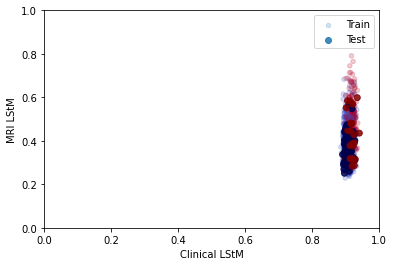

AUC Score:  0.8671328671328672


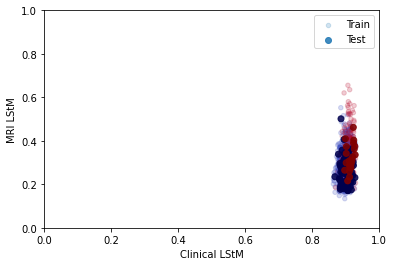

AUC Score:  0.8451948051948053


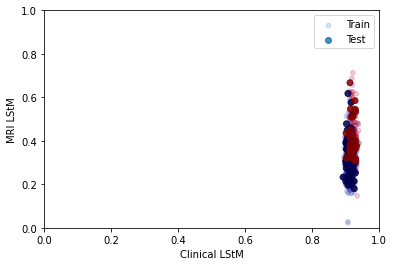

AUC Score:  0.852987012987013


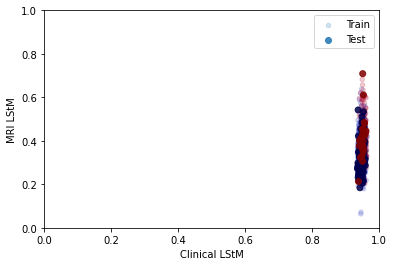

AUC Score:  0.736103896103896


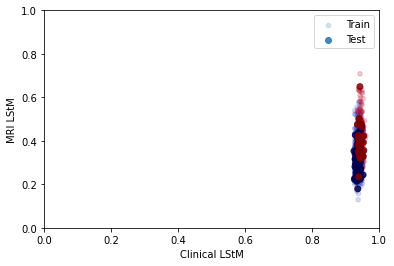

AUC Score:  0.8903896103896104


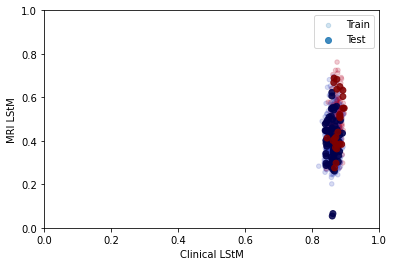

AUC Score:  0.8322077922077923


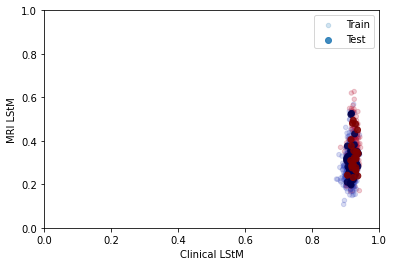

AUC Score:  0.7625974025974026


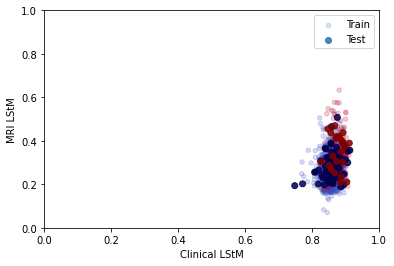

AUC Score:  0.8173076923076924


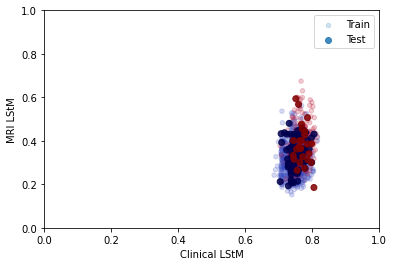

AUC Score:  0.7899797570850202


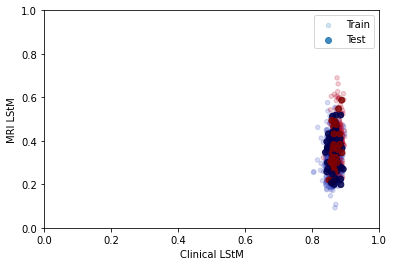

AUC Score:  0.5116396761133604
Mean AUC score:  0.790554051211946
Confidence Interval:  0.10888611998589533
All:  [0.8671328671328672, 0.8451948051948053, 0.852987012987013, 0.736103896103896, 0.8903896103896104, 0.8322077922077923, 0.7625974025974026, 0.8173076923076924, 0.7899797570850202, 0.5116396761133604]


In [ ]:
n_features = 18
n_split= 10
skf = StratifiedKFold(n_splits=n_split, shuffle=False)
mean = 0
accuracy = []
mean_list=[]
idx = 0
preds_stat=np.array([])

for train_index, test_index in skf.split(df_all_combined, y_combined):#df_all, y):
    Xtrain = df_all_combined[train_index]
    ytrain = y[train_index]
    Xtest = df_all_combined[test_index]
    ytest = y[test_index]

    Xtrain_img = Xtrain[:,:, n_features:]
    Xtest_img = Xtest[:,:, n_features:]
    Xtrain_cli = Xtrain[:,:, :n_features]
    Xtest_cli = Xtest[:,:, :n_features]

    ypred_img_train = img_shallow_models[idx].__call__(Xtrain_img)
    ypred_img_test = img_shallow_models[idx].__call__(Xtest_img)

    ypred_cli_train = climodel_shallow_models[idx].__call__(Xtrain_cli)
    ypred_cli_test = climodel_shallow_models[idx].__call__(Xtest_cli)
    
    # Plot predictions of the two models
    plt.scatter(ypred_cli_train, ypred_img_train, c=ytrain,alpha=0.2,label="Train",cmap="coolwarm", marker="o", s=20)
    plt.scatter(ypred_cli_test, ypred_img_test, c=ytest,alpha=0.85,label="Test",cmap="seismic")
    plt.xlabel("Clinical LStM")
    plt.legend()
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel("MRI LStM")
    plt.show()

    idx+=1

    # Make ensample
    preds_train = np.squeeze(np.array([ypred_cli_train, ypred_img_train])).T
    preds_test = np.squeeze(np.array([ypred_cli_test, ypred_img_test])).T

    #neigh = KNeighborsClassifier(n_neighbors=3)
    #neigh.fit(preds_train, ytrain)
    #y_pred = neigh.predict(preds_test)        

    clf = GaussianNB()
    #clf = KNeighborsClassifier(n_neighbors=15)
    clf.fit(preds_train, ytrain)
    y_pred = clf.predict_proba(preds_test)[:,1]
    #clf = LogisticRegression(random_state=0).fit(preds_train, ytrain)
    #y_pred = clf.predict_proba(preds_test)
    
    print("AUC Score: ", roc_auc_score(ytest.astype(float), y_pred)) 
    mean_list.append(roc_auc_score(ytest.astype(float), y_pred))

    preds_stat = np.concatenate([preds_stat,y_pred])



print("Mean AUC score: ", np.mean(mean_list))    
print("Confidence Interval: ", get_standard_diviation(mean_list))
print("All: ", mean_list)

In [ ]:
preds_stat.tofile("/content/gdrive/My Drive/Speciale/ensamble_comb.csv")
np.array(y_combined).tofile("/content/gdrive/My Drive/Speciale/y_ensamble_comb.csv")

In [ ]:
10-nn
Mean accuracy score:  0.8328424996056576
Confidence Interval:  0.07336071988410256

NB
Mean accuracy score:  0.8501833692623165
Confidence Interval:  0.07040671693163585

### validation



In [ ]:
n_features = 18

#split into clin data and img data
df_all_img = df_all[:,:, n_features:]
df_all_cli = df_all[:,:, :n_features]


df_all_val_img = df_all_val[:,:, n_features:]
df_all_val_cli = df_all_val[:,:, :n_features]

#Fit to all training data
img_model = img_shallow_models[0]
cli_model = climodel_shallow_models[0]

history_img = img_model.fit(df_all_img, y, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'
history_cli = cli_model.fit(df_all_cli, y, epochs=1000, validation_split=0.20, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15), batch_size=25) #batch_size=75,monitor='val_loss'

#predict 
ypred_img_train = img_model.predict(df_all_img)
ypred_img_val = img_model.predict(df_all_val_img)

ypred_cli_train = cli_model.predict(df_all_cli)
ypred_cli_val = cli_model.predict(df_all_val_cli)

 
# Make ensample
preds_train = np.squeeze(np.array([ypred_cli_train, ypred_img_train])).T
preds_val = np.squeeze(np.array([ypred_img_val, ypred_cli_val])).T

clf = GaussianNB()
clf.fit(preds_train, y)
y_pred = clf.predict_proba(preds_val)[:,1]

print("AUC Score: ", roc_auc_score(y_val.astype(float), y_pred)) 

Epoch 1/1000
33/33 [==============================] - 3s 80ms/step - loss: 0.3699 - auc: 0.7520 - val_loss: 1.3491 - val_auc: 0.6805
Epoch 2/1000
33/33 [==============================] - 3s 94ms/step - loss: 0.3779 - auc: 0.7447 - val_loss: 1.2967 - val_auc: 0.6810
Epoch 3/1000
33/33 [==============================] - 3s 83ms/step - loss: 0.3748 - auc: 0.7518 - val_loss: 1.3127 - val_auc: 0.6840
Epoch 4/1000
33/33 [==============================] - 2s 72ms/step - loss: 0.3726 - auc: 0.7538 - val_loss: 1.3043 - val_auc: 0.6776
Epoch 5/1000
33/33 [==============================] - 3s 90ms/step - loss: 0.3663 - auc: 0.7742 - val_loss: 1.3121 - val_auc: 0.6811
Epoch 6/1000
33/33 [==============================] - 1s 42ms/step - loss: 0.3663 - auc: 0.7673 - val_loss: 1.3425 - val_auc: 0.6780
Epoch 7/1000
33/33 [==============================] - 1s 38ms/step - loss: 0.3690 - auc: 0.7614 - val_loss: 1.2900 - val_auc: 0.6812
Epoch 8/1000
33/33 [==============================] - 2s 47ms/step - 

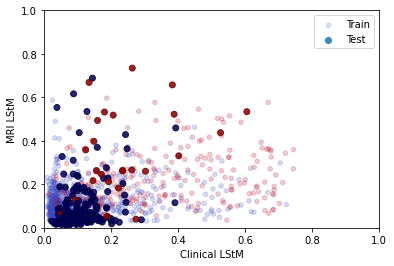

In [ ]:
# Plot predictions of the two models
plt.scatter(ypred_cli_train, ypred_img_train, c=y,alpha=0.2,label="Train",cmap="coolwarm", marker="o", s=20)
plt.scatter(ypred_img_val, ypred_cli_val, c=y_val,alpha=0.85,label="Test",cmap="seismic")
plt.xlabel("Clinical LStM")
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("MRI LStM")
plt.show()